# **Hypothesis testing**

## Objectives

* Perform additional exploratory data analysis to understand data distribution and correlations between variables.

## Inputs

* Cleaned data saved in https://github.com/8osco/academic_performance_analysis/blob/main/data/inputs/cleaned/edu_data_cleaned.csv
* Initial analyses performed in [1_data_etl.ipynb](https://github.com/8osco/academic_performance_analysis/blob/main/jupyter_notebooks/1_data_etl.ipynb)


## Outputs

* Overview on data distribution and correlations between variables.

# 1 Import packages


Import relevant packages required for data analysis and visualisation.

In [1]:
# Import NumPy, Pandas, Matplotlib, Seaborn and Plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 2 Data extract and familiarisation

Read in the cleaned csv file and familiarise with the file structure at a high level, through use of various dataframe methods:

In [2]:
# Load the dataset and display the first few rows
df = pd.read_csv('../data/inputs/cleaned/edu_data_cleaned.csv')
df.head()

,gender,nationality,place_of_birth,education_stage,grade,classroom_id,subject,semester,parent_involved,raised_hands,resource_visits,announcements_viewed,discussion_participation,parent_answered_survey,parent_school_satisfaction,absence_category,pass_fail_status
0,male,kuwait,kuwait,lowerschool,g-04,a,it,first,father,15,16,2,20,yes,good,low,pass
1,male,kuwait,kuwait,lowerschool,g-04,a,it,first,father,20,20,3,25,yes,good,low,pass
2,male,kuwait,kuwait,lowerschool,g-04,a,it,first,father,10,7,0,30,no,bad,high,fail
3,male,kuwait,kuwait,lowerschool,g-04,a,it,first,father,30,25,5,35,no,bad,high,fail
4,male,kuwait,kuwait,lowerschool,g-04,a,it,first,father,40,50,12,50,no,bad,high,pass


In [3]:
# Display the shape of the DataFrame
df.shape

(478, 17)

In [4]:
# Display the column data types and check for null or missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   gender                      478 non-null    object
 1   nationality                 478 non-null    object
 2   place_of_birth              478 non-null    object
 3   education_stage             478 non-null    object
 4   grade                       478 non-null    object
 5   classroom_id                478 non-null    object
 6   subject                     478 non-null    object
 7   semester                    478 non-null    object
 8   parent_involved             478 non-null    object
 9   raised_hands                478 non-null    int64 
 10  resource_visits             478 non-null    int64 
 11  announcements_viewed        478 non-null    int64 
 12  discussion_participation    478 non-null    int64 
 13  parent_answered_survey      478 non-null    object

1. Students who raised their hands more often were more likely to pass.

First, we should decide whether we use a parametric or non-parametric statistical test.

One of the criteria for parametric tests to be used is that the data is normally distributed, which is to be tested below.

We start by plotting the frequency of hand-raising separately for pass and fail, using Seaborn histograms.  We also have QQ plots alongside to help visualise how close the data is to a normal distribution, using Pingouin (as learnt from the Code Institute course).

In [5]:
# Install Pingouin
#%pip install pingouin

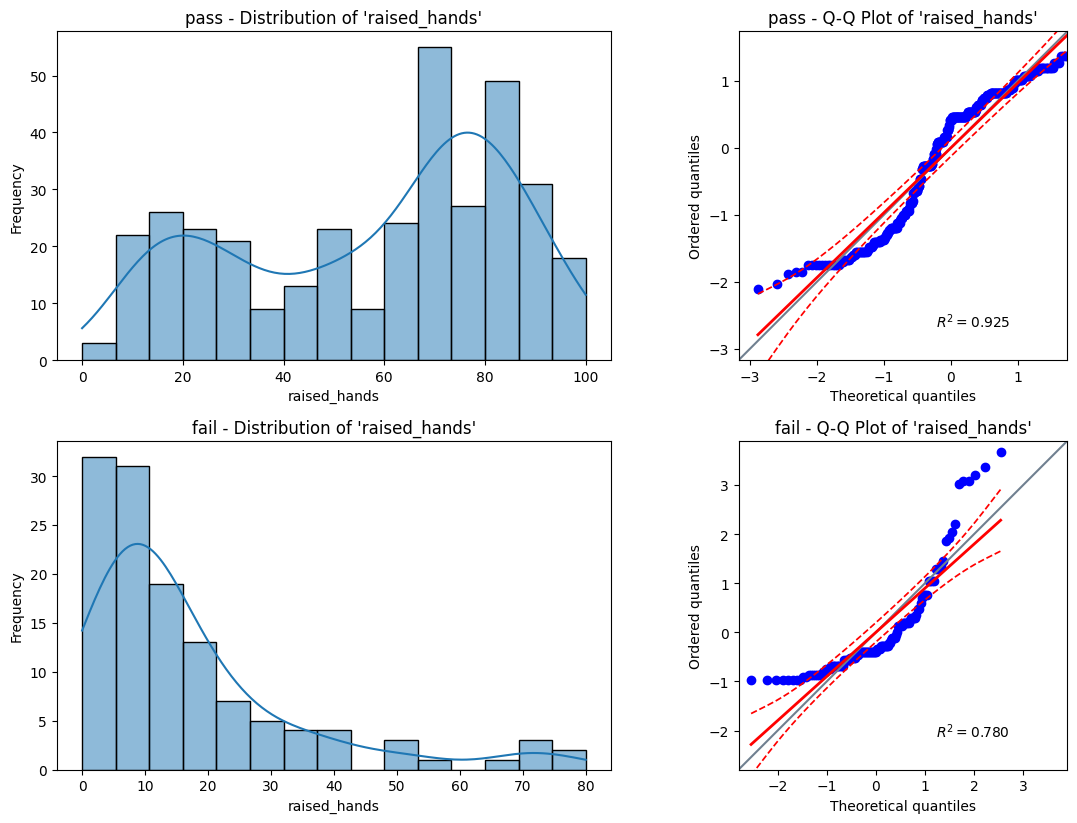

In [6]:
import pingouin as pg

# Setup for plots
plt.figure(figsize=(12, 12))  # set figure size

for i, c in enumerate(['pass', 'fail']):   # iterate over 'pass' and 'fail' categories
    data = df[df['pass_fail_status'] == c]['raised_hands'] # filter data for current category
    
    # Histogram
    plt.subplot(3, 2, 2*i+1) # create subplot for histogram
    sns.histplot(data, kde=True, bins=15)  # include KDE for better visualization and set number of bins
    plt.title(f"{c} - Distribution of 'raised_hands'") # set title
    plt.xlabel("raised_hands") # set x-axis label
    plt.ylabel("Frequency") # set y-axis label
    
    # Q-Q Plot
    plt.subplot(3, 2, 2*i+2) # create subplot for Q-Q plot
    pg.qqplot(data, dist='norm')  # compare to normal distribution
    plt.title(f"{c} - Q-Q Plot of 'raised_hands'") # set title

plt.tight_layout() # adjust layout to prevent overlap
plt.show()

The histograms suggest that they are not normally distributed.  On the other hand, R-square's in the QQ plots are very high, reflecting close alignment between the quantiles of the data and the quantiles of a theoretical normal distribution.  It is noted however that R-square in a Q-Q plot is not a test of normality.  

To proceed with the normality test, we run the Shapiro-Wilk test below, using Pingouin.

In [ ]:
results = pg.normality(data=df, dv='raised_hands', group='pass_fail_status', method='shapiro') # Shapiro-Wilk test for normality (with significance level set to 0.05 as default)

print(results)

                         W          pval  normal
pass_fail_status                                
pass              0.921672  1.274802e-12   False
fail              0.780451  2.149761e-12   False


As shown in the last column of the output above, the data is not normally distributed, and so we will use a non-parametric test for the hypothesis testing.  Here we use Kruskal-Wallis test.

In [ ]:
#  - null hypothesis: the distributions of 'raised_hands' are the same across 'pass' and 'fail' groups
# significant level is set to 0.05 by default in Pingouin
result = pg.kruskal(data=df, dv='raised_hands', between='pass_fail_status')

print(result)

                   Source  ddof1           H         p-unc
Kruskal  pass_fail_status      1  168.045052  1.977702e-38


Since p-value (1.977702e-38) is lower than our significant level (assumed to be 0.05), there is enough evidence to reject the null hypothesis and conclude that the distributions of 'raised_hands' are different between the 'pass' and 'fail' groups.  This is consistent with our observations from the histogram plots above.

Whilst the Kruskal-Wallis test tells us that the distributions of the two groups are different, it does not say whether the pass group has higher number of raised hands.

We can compute mean and variance to help with this.

In [ ]:
for c in ['pass', 'fail']: # iterate over 'pass' and 'fail' categories
    group_data = df[df['pass_fail_status'] == c]['raised_hands'] # filter data for current category
    mean_val = group_data.mean() # calculate mean
    var_val = group_data.var() # calculate variance
    
    print(f"{c.upper()} group:")
    print(f"  Mean      = {mean_val:.2f}")
    print(f"  Variance  = {var_val:.2f}\n")

PASS group:
  Mean      = 57.53
  Variance  = 744.98

FAIL group:
  Mean      = 16.84
  Variance  = 299.17



Here, we can see that pass group has a higher mean of raised hands (57.53) compared to the fail group (16.84). 
The variance is also much higher in the pass group, compared to the fail group.  This suggests that students who passed tend to raise their hands more frequently on average, but also over a wider range.

2. Students who visited more resources were more likely to pass.

We will assess the hypothesis through use of similar plots:

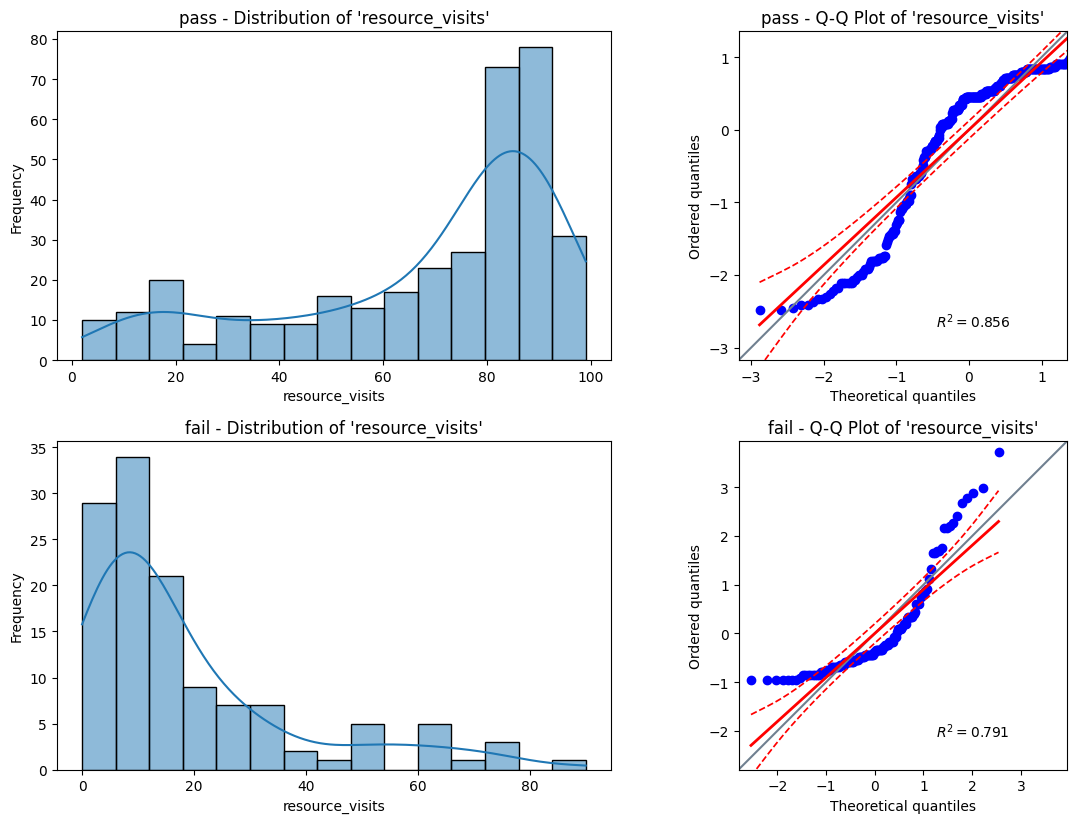

In [11]:
# Setup for plots
plt.figure(figsize=(12, 12))  # set figure size

for i, c in enumerate(['pass', 'fail']):   # iterate over 'pass' and 'fail' categories
    data = df[df['pass_fail_status'] == c]['resource_visits'] # filter data for current category
    
    # Histogram
    plt.subplot(3, 2, 2*i+1) # create subplot for histogram
    sns.histplot(data, kde=True, bins=15)  # include KDE for better visualization and set number of bins
    plt.title(f"{c} - Distribution of 'resource_visits'") # set title
    plt.xlabel("resource_visits") # set x-axis label
    plt.ylabel("Frequency") # set y-axis label
    
    # Q-Q Plot
    plt.subplot(3, 2, 2*i+2) # create subplot for Q-Q plot
    pg.qqplot(data, dist='norm')  # compare to normal distribution
    plt.title(f"{c} - Q-Q Plot of 'resource_visits'") # set title

plt.tight_layout() # adjust layout to prevent overlap
plt.show()

It can be seen that the distributions 

3. Students with a parent (or guardian) involved were more likely to pass.

4. Female students had a higher pass rate than male students.

Calculate mean/variance for the hypothesis!!

Show in dashboard also!  i.e. do something with the data, before you draw the chart, and not just plugging columns to the chart!